In [1]:
import os 
import numpy as np
import keras
import tensorflow as tf 
import matplotlib.pyplot as plt

from keras import layers
from PIL import Image

2024-07-05 02:57:44.458846: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 02:57:44.458983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 02:57:44.584297: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   310M      0  0:00:02  0:00:02 --:--:--  310M


In [4]:
!unzip -q kagglecatsanddogs_5340.zip 
!ls

 CDLA-Permissive-2.0.pdf   __notebook__.ipynb	       'readme[1].txt'
 PetImages		   kagglecatsanddogs_5340.zip


In [5]:
!ls PetImages

Cat  Dog


In [6]:
num_deleted = 0 
folder = "/kaggle/working/PetImages"

folders = [ os.path.join(folder, path) for path in os.listdir(folder) ]

for fold in folders:
    for fname in os.listdir(fold):
        fpath = os.path.join(fold, fname) 
        
        try:
            Image.open(fpath) 
            fobj = open(fpath, "rb") 
            is_jfif = b"JFIF" in fobj.peek(10) 
        except (IOError, SyntaxError) as e:
            os.remove(fpath) 
            num_deleted+=1
            
        finally:
            fobj.close() 
            
        if not is_jfif:
            if os.path.exists(fpath):  
                os.remove(fpath) 
                num_deleted +=1 
            


print(f"Total {num_deleted} images are deleted")

Total 1592 images are deleted


In [7]:
class cnf:
    image_size = [180,180,3]
    batch_size = 64 
    seed = 24
    train_size = 0.9 
    
    
    
np.random.seed(cnf.seed)

In [8]:
cat_path = os.path.join(folder, "Cat") 
dog_path = os.path.join(folder, "Dog")

cat_paths = [os.path.join(cat_path, file_name) for file_name in os.listdir(cat_path)]
dog_paths = [os.path.join(dog_path, file_name) for file_name in os.listdir(dog_path)] 

cat_path_file_types = [file_path.split(".")[-1] for file_path in cat_paths] 
dog_path_file_types = [file_path.split(".")[-1] for file_path in dog_paths] 


print(f"Cat images : {len(cat_paths)}")
print(f"Dog images : {len(dog_paths)}")

print(f"Cat path file types : {set(cat_path_file_types)}")
print(f"Dog path file types : {set(dog_path_file_types)}")
print(f"Total images : {len(cat_paths) + len(dog_paths)}")

Cat images : 11741
Dog images : 11669
Cat path file types : {'jpg'}
Dog path file types : {'jpg'}
Total images : 23410


In [9]:
cat_paths = [cat_path for cat_path in cat_paths if cat_path.split(".")[-1] == "jpg"]
dog_paths = [dog_path for dog_path in dog_paths if dog_path.split(".")[-1] == 'jpg'] 

cat_path_file_types = [file_path.split(".")[-1] for file_path in cat_paths] 
dog_path_file_types = [file_path.split(".")[-1] for file_path in dog_paths] 

print(f"Cat images : {len(cat_paths)}")
print(f"Dog images : {len(dog_paths)}")

print(f"Cat path file types : {set(cat_path_file_types)}")
print(f"Dog path file types : {set(dog_path_file_types)}")
print(f"Total images : {len(cat_paths) + len(dog_paths)}")

Cat images : 11741
Dog images : 11669
Cat path file types : {'jpg'}
Dog path file types : {'jpg'}
Total images : 23410


In [10]:
def read_file(img_path):
    img = tf.io.read_file(img_path) 
    img = tf.io.decode_jpeg(img, channels=3) 
    img = tf.image.resize(img, size= cnf.image_size[:-1])
    img = tf.cast(img, tf.float32) / 255.0 
    return img
    
    

In [11]:
#cat - 0 
#dog - 1

cat_labels = [0,]* len(cat_paths) 
dog_labels = [1,]* len(dog_paths) 

img_paths = cat_paths + dog_paths 
labels = cat_labels + dog_labels

img_paths = np.array(img_paths) 
labels = np.array(labels) 

#random indexes 
idx = np.random.permutation(len(img_paths)) 
img_paths = img_paths[idx] 
labels = labels[idx] 

print(img_paths[:10]) 
print(labels[:10])

['/kaggle/working/PetImages/Dog/4317.jpg'
 '/kaggle/working/PetImages/Cat/1002.jpg'
 '/kaggle/working/PetImages/Cat/10099.jpg'
 '/kaggle/working/PetImages/Cat/8474.jpg'
 '/kaggle/working/PetImages/Dog/9060.jpg'
 '/kaggle/working/PetImages/Cat/4447.jpg'
 '/kaggle/working/PetImages/Dog/590.jpg'
 '/kaggle/working/PetImages/Dog/19.jpg'
 '/kaggle/working/PetImages/Cat/9799.jpg'
 '/kaggle/working/PetImages/Cat/9702.jpg']
[1 0 0 0 1 0 1 1 0 0]


In [12]:
train_size = int(len(img_paths) * cnf.train_size) 
train_imgs = img_paths[:train_size] 
train_lbls = labels[:train_size] 

val_imgs = img_paths[train_size:] 
val_lbls = labels[train_size:] 

print(f"Total images : {len(img_paths)}")
print(len(train_imgs) + len(val_imgs))
print(f"Total train images : {len(train_imgs)}") 
print(f"Total Validation images : {len(val_imgs)}")


Total images : 23410
23410
Total train images : 21069
Total Validation images : 2341


In [13]:
train_ds = tf.data.Dataset.from_tensor_slices((train_imgs, train_lbls)) 
val_ds = tf.data.Dataset.from_tensor_slices((val_imgs, val_lbls)) 

def process_ds(img_path, label):
    img = read_file(img_path) 
    return img, label

train_ds = train_ds.map(process_ds).batch(cnf.batch_size).prefetch(tf.data.AUTOTUNE) 
val_ds = val_ds.map(process_ds).batch(cnf.batch_size).prefetch(tf.data.AUTOTUNE) 


    

In [14]:
images, labels = next(iter(train_ds)) 
images.shape, labels.shape

(TensorShape([64, 180, 180, 3]), TensorShape([64]))

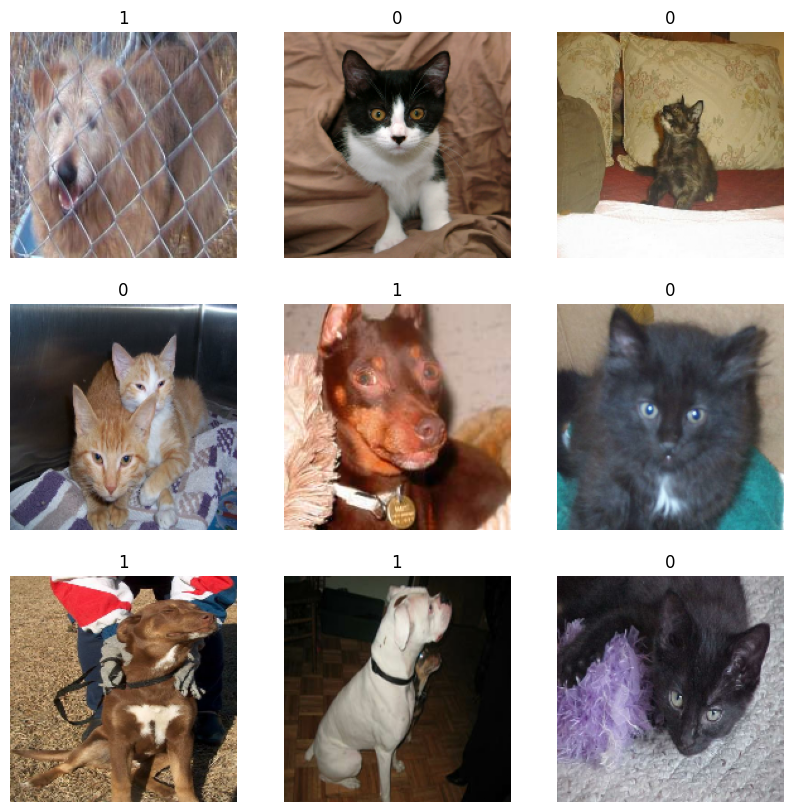

In [15]:
plt.figure(figsize=(10,10)) 

for i  in range(9):
    ax = plt.subplot(3,3,i+1) 
    plt.imshow(images[i]) 
    plt.title(f"{labels[i]}") 
    plt.axis('off') 
    
plt.show()

In [16]:
def get_model():
    inputs = layers.Input(shape=(cnf.image_size)) 
    x = inputs 
    x = layers.Conv2D(128,3,strides=2, padding='same')(x) 
    x = layers.BatchNormalization()(x) 
    x = layers.Activation('relu')(x) 
    
    prev_block_activation = x 
    
    for size in [256,512,728]:
        x = layers.Activation("relu")(x) 
        x = layers.SeparableConv2D(size, 3, padding='same')(x) 
        x = layers.BatchNormalization()(x) 
        
        x = layers.Activation("relu")(x) 
        x = layers.SeparableConv2D(size, 3, padding='same')(x) 
        x = layers.BatchNormalization()(x) 
        
        x = layers.MaxPooling2D(3, strides=2, padding='same')(x) 
        
        residual = layers.Conv2D(size, 1, strides=2, padding='same')(prev_block_activation) 
        x = layers.add([x, residual]) 
        prev_block_activation = x
        
    x = layers.SeparableConv2D(1024, 3, padding='same')(x) 
    x = layers.BatchNormalization()(x) 
    x = layers.Activation("relu")(x) 
    x = layers.GlobalAveragePooling2D()(x) 
    
    x = layers.Dropout(0.25)(x) 
    x = layers.Dense(1, activation=None)(x) 
    return keras.models.Model(inputs, x) 

    

In [17]:
model = get_model() 
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 90, 90,    │      3,584 │ input_layer[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 90, 90,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 90, 90,    │          0 │ activation[0][0]  │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 90, 90,    │     34,176 │ activation_1[0][… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 90, 90,    │     68,096 │ activation_2[0][… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 45, 45,    │     33,024 │ activation[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 45, 45,    │          0 │ max_pooling2d[0]… │
│                     │ 256)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 45, 45,    │          0 │ add[0][0]         │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 45, 45,    │    133,888 │ activation_3[0][… │
│ (SeparableConv2D)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 45,    │      2,048 │ separable_conv2d… │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 45, 45,    │          0 │ batch_normalizat

 Total params: 2,731,065 (10.42 MB)

 Trainable params: 2,722,777 (10.39 MB)

 Non-trainable params: 8,288 (32.38 KB)

In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
callbacks = [
    keras.callbacks.ModelCheckpoint("dogorcat.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(patience=2)
]

model.compile(
optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name='acc')]
)

In [19]:
epochs = 15

model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/15


I0000 00:00:1720148350.478323      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 98/330 ━━━━━━━━━━━━━━━━━━━━ 1:02 269ms/step - acc: 0.5797 - loss: 0.7258

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


106/330 ━━━━━━━━━━━━━━━━━━━━ 1:00 269ms/step - acc: 0.5821 - loss: 0.7213

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


111/330 ━━━━━━━━━━━━━━━━━━━━ 58s 269ms/step - acc: 0.5834 - loss: 0.7187

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


131/330 ━━━━━━━━━━━━━━━━━━━━ 53s 269ms/step - acc: 0.5890 - loss: 0.7093

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


193/330 ━━━━━━━━━━━━━━━━━━━━ 36s 269ms/step - acc: 0.6044 - loss: 0.6866

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


233/330 ━━━━━━━━━━━━━━━━━━━━ 26s 269ms/step - acc: 0.6122 - loss: 0.6757

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


245/330 ━━━━━━━━━━━━━━━━━━━━ 22s 269ms/step - acc: 0.6143 - loss: 0.6729

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


279/330 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step - acc: 0.6201 - loss: 0.6650

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


298/330 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - acc: 0.6231 - loss: 0.6611

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


315/330 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - acc: 0.6255 - loss: 0.6577

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - acc: 0.6276 - loss: 0.6550

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 170s 352ms/step - acc: 0.6277 - loss: 0.6548 - val_acc: 0.4951 - val_loss: 1.0655
Epoch 2/15
 98/330 ━━━━━━━━━━━━━━━━━━━━ 1:02 269ms/step - acc: 0.7620 - loss: 0.4916

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


106/330 ━━━━━━━━━━━━━━━━━━━━ 1:00 269ms/step - acc: 0.7627 - loss: 0.4906

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


111/330 ━━━━━━━━━━━━━━━━━━━━ 58s 269ms/step - acc: 0.7631 - loss: 0.4900

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


131/330 ━━━━━━━━━━━━━━━━━━━━ 53s 269ms/step - acc: 0.7643 - loss: 0.4879

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


193/330 ━━━━━━━━━━━━━━━━━━━━ 36s 269ms/step - acc: 0.7689 - loss: 0.4798

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


233/330 ━━━━━━━━━━━━━━━━━━━━ 26s 269ms/step - acc: 0.7714 - loss: 0.4749

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


245/330 ━━━━━━━━━━━━━━━━━━━━ 22s 269ms/step - acc: 0.7722 - loss: 0.4735

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


279/330 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step - acc: 0.7744 - loss: 0.4695

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


298/330 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - acc: 0.7755 - loss: 0.4673

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


315/330 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - acc: 0.7765 - loss: 0.4655

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - acc: 0.7773 - loss: 0.4640

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 91s 276ms/step - acc: 0.7774 - loss: 0.4638 - val_acc: 0.6783 - val_loss: 1.0855
Epoch 3/15
 98/330 ━━━━━━━━━━━━━━━━━━━━ 1:02 269ms/step - acc: 0.8429 - loss: 0.3433

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


106/330 ━━━━━━━━━━━━━━━━━━━━ 1:00 269ms/step - acc: 0.8429 - loss: 0.3430

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


111/330 ━━━━━━━━━━━━━━━━━━━━ 58s 269ms/step - acc: 0.8430 - loss: 0.3428

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


131/330 ━━━━━━━━━━━━━━━━━━━━ 53s 269ms/step - acc: 0.8431 - loss: 0.3420

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


193/330 ━━━━━━━━━━━━━━━━━━━━ 36s 269ms/step - acc: 0.8455 - loss: 0.3374

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


233/330 ━━━━━━━━━━━━━━━━━━━━ 26s 269ms/step - acc: 0.8474 - loss: 0.3343

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


245/330 ━━━━━━━━━━━━━━━━━━━━ 22s 269ms/step - acc: 0.8480 - loss: 0.3333

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


279/330 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step - acc: 0.8495 - loss: 0.3306

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


298/330 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - acc: 0.8503 - loss: 0.3292

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


315/330 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - acc: 0.8509 - loss: 0.3280

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - acc: 0.8514 - loss: 0.3271

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 91s 276ms/step - acc: 0.8514 - loss: 0.3270 - val_acc: 0.8108 - val_loss: 0.5842
Epoch 4/15
 98/330 ━━━━━━━━━━━━━━━━━━━━ 1:02 269ms/step - acc: 0.8846 - loss: 0.2524

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


106/330 ━━━━━━━━━━━━━━━━━━━━ 1:00 269ms/step - acc: 0.8852 - loss: 0.2515

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


111/330 ━━━━━━━━━━━━━━━━━━━━ 58s 269ms/step - acc: 0.8856 - loss: 0.2511

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


131/330 ━━━━━━━━━━━━━━━━━━━━ 53s 269ms/step - acc: 0.8867 - loss: 0.2495

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


193/330 ━━━━━━━━━━━━━━━━━━━━ 36s 269ms/step - acc: 0.8899 - loss: 0.2447

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


233/330 ━━━━━━━━━━━━━━━━━━━━ 26s 269ms/step - acc: 0.8916 - loss: 0.2420

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


245/330 ━━━━━━━━━━━━━━━━━━━━ 22s 269ms/step - acc: 0.8921 - loss: 0.2412

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


279/330 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step - acc: 0.8933 - loss: 0.2389

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


298/330 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - acc: 0.8939 - loss: 0.2379

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


315/330 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - acc: 0.8944 - loss: 0.2370

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - acc: 0.8948 - loss: 0.2363

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 91s 276ms/step - acc: 0.8948 - loss: 0.2363 - val_acc: 0.7317 - val_loss: 0.5289
Epoch 5/15
 98/330 ━━━━━━━━━━━━━━━━━━━━ 1:02 269ms/step - acc: 0.9105 - loss: 0.1920

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


106/330 ━━━━━━━━━━━━━━━━━━━━ 1:00 269ms/step - acc: 0.9109 - loss: 0.1918

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


111/330 ━━━━━━━━━━━━━━━━━━━━ 58s 269ms/step - acc: 0.9111 - loss: 0.1916

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


131/330 ━━━━━━━━━━━━━━━━━━━━ 53s 269ms/step - acc: 0.9122 - loss: 0.1906

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


193/330 ━━━━━━━━━━━━━━━━━━━━ 36s 269ms/step - acc: 0.9155 - loss: 0.1869

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


233/330 ━━━━━━━━━━━━━━━━━━━━ 26s 269ms/step - acc: 0.9171 - loss: 0.1847

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


245/330 ━━━━━━━━━━━━━━━━━━━━ 22s 269ms/step - acc: 0.9176 - loss: 0.1841

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


279/330 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step - acc: 0.9187 - loss: 0.1823

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


298/330 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - acc: 0.9193 - loss: 0.1815

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


315/330 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - acc: 0.9197 - loss: 0.1809

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - acc: 0.9201 - loss: 0.1803

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 91s 276ms/step - acc: 0.9201 - loss: 0.1802 - val_acc: 0.8783 - val_loss: 0.3755
Epoch 6/15
 98/330 ━━━━━━━━━━━━━━━━━━━━ 1:02 268ms/step - acc: 0.9396 - loss: 0.1411

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


106/330 ━━━━━━━━━━━━━━━━━━━━ 1:00 268ms/step - acc: 0.9398 - loss: 0.1410

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


111/330 ━━━━━━━━━━━━━━━━━━━━ 58s 268ms/step - acc: 0.9398 - loss: 0.1409

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


131/330 ━━━━━━━━━━━━━━━━━━━━ 53s 268ms/step - acc: 0.9400 - loss: 0.1405

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


193/330 ━━━━━━━━━━━━━━━━━━━━ 36s 269ms/step - acc: 0.9413 - loss: 0.1383

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


233/330 ━━━━━━━━━━━━━━━━━━━━ 26s 269ms/step - acc: 0.9420 - loss: 0.1370

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


245/330 ━━━━━━━━━━━━━━━━━━━━ 22s 269ms/step - acc: 0.9422 - loss: 0.1366

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


279/330 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step - acc: 0.9426 - loss: 0.1358

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


298/330 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - acc: 0.9428 - loss: 0.1355

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


315/330 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - acc: 0.9429 - loss: 0.1351

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - acc: 0.9431 - loss: 0.1348

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 91s 276ms/step - acc: 0.9431 - loss: 0.1348 - val_acc: 0.8787 - val_loss: 0.3111
Epoch 7/15
 98/330 ━━━━━━━━━━━━━━━━━━━━ 1:02 269ms/step - acc: 0.9529 - loss: 0.1103

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


106/330 ━━━━━━━━━━━━━━━━━━━━ 1:00 269ms/step - acc: 0.9532 - loss: 0.1097

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


111/330 ━━━━━━━━━━━━━━━━━━━━ 58s 269ms/step - acc: 0.9533 - loss: 0.1093

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


131/330 ━━━━━━━━━━━━━━━━━━━━ 53s 269ms/step - acc: 0.9539 - loss: 0.1078

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


193/330 ━━━━━━━━━━━━━━━━━━━━ 36s 269ms/step - acc: 0.9550 - loss: 0.1056

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


233/330 ━━━━━━━━━━━━━━━━━━━━ 26s 269ms/step - acc: 0.9556 - loss: 0.1047

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


245/330 ━━━━━━━━━━━━━━━━━━━━ 22s 269ms/step - acc: 0.9558 - loss: 0.1044

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


279/330 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step - acc: 0.9562 - loss: 0.1037

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


298/330 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - acc: 0.9564 - loss: 0.1034

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


315/330 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - acc: 0.9565 - loss: 0.1032

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - acc: 0.9566 - loss: 0.1030

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 91s 276ms/step - acc: 0.9566 - loss: 0.1029 - val_acc: 0.8296 - val_loss: 0.4044
Epoch 8/15
 98/330 ━━━━━━━━━━━━━━━━━━━━ 1:02 269ms/step - acc: 0.9640 - loss: 0.0863

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


106/330 ━━━━━━━━━━━━━━━━━━━━ 1:00 269ms/step - acc: 0.9641 - loss: 0.0858

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


111/330 ━━━━━━━━━━━━━━━━━━━━ 58s 269ms/step - acc: 0.9642 - loss: 0.0856

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


131/330 ━━━━━━━━━━━━━━━━━━━━ 53s 269ms/step - acc: 0.9643 - loss: 0.0849

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


193/330 ━━━━━━━━━━━━━━━━━━━━ 36s 269ms/step - acc: 0.9646 - loss: 0.0839

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


233/330 ━━━━━━━━━━━━━━━━━━━━ 26s 269ms/step - acc: 0.9649 - loss: 0.0833

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


245/330 ━━━━━━━━━━━━━━━━━━━━ 22s 269ms/step - acc: 0.9650 - loss: 0.0831

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


279/330 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step - acc: 0.9652 - loss: 0.0825

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


298/330 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - acc: 0.9653 - loss: 0.0822

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


315/330 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - acc: 0.9654 - loss: 0.0820

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - acc: 0.9655 - loss: 0.0818

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 91s 276ms/step - acc: 0.9655 - loss: 0.0818 - val_acc: 0.9163 - val_loss: 0.2343
Epoch 9/15
 98/330 ━━━━━━━━━━━━━━━━━━━━ 1:02 269ms/step - acc: 0.9771 - loss: 0.0622

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


106/330 ━━━━━━━━━━━━━━━━━━━━ 1:00 269ms/step - acc: 0.9768 - loss: 0.0626

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


111/330 ━━━━━━━━━━━━━━━━━━━━ 58s 269ms/step - acc: 0.9766 - loss: 0.0628

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


131/330 ━━━━━━━━━━━━━━━━━━━━ 53s 269ms/step - acc: 0.9760 - loss: 0.0636

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


193/330 ━━━━━━━━━━━━━━━━━━━━ 36s 269ms/step - acc: 0.9748 - loss: 0.0650

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


233/330 ━━━━━━━━━━━━━━━━━━━━ 26s 269ms/step - acc: 0.9745 - loss: 0.0651

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


245/330 ━━━━━━━━━━━━━━━━━━━━ 22s 269ms/step - acc: 0.9744 - loss: 0.0651

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


279/330 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step - acc: 0.9743 - loss: 0.0652

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


298/330 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - acc: 0.9742 - loss: 0.0652

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


315/330 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - acc: 0.9741 - loss: 0.0652

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - acc: 0.9741 - loss: 0.0652

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 91s 276ms/step - acc: 0.9741 - loss: 0.0652 - val_acc: 0.8445 - val_loss: 0.3506
Epoch 10/15
 98/330 ━━━━━━━━━━━━━━━━━━━━ 1:02 269ms/step - acc: 0.9812 - loss: 0.0512

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


106/330 ━━━━━━━━━━━━━━━━━━━━ 1:00 269ms/step - acc: 0.9812 - loss: 0.0512

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


111/330 ━━━━━━━━━━━━━━━━━━━━ 58s 269ms/step - acc: 0.9812 - loss: 0.0513

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


131/330 ━━━━━━━━━━━━━━━━━━━━ 53s 269ms/step - acc: 0.9810 - loss: 0.0516

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


193/330 ━━━━━━━━━━━━━━━━━━━━ 36s 269ms/step - acc: 0.9808 - loss: 0.0517

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


233/330 ━━━━━━━━━━━━━━━━━━━━ 26s 269ms/step - acc: 0.9807 - loss: 0.0517

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


245/330 ━━━━━━━━━━━━━━━━━━━━ 22s 269ms/step - acc: 0.9806 - loss: 0.0517

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


279/330 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step - acc: 0.9805 - loss: 0.0517

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


298/330 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - acc: 0.9805 - loss: 0.0517

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


315/330 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - acc: 0.9805 - loss: 0.0516

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - acc: 0.9805 - loss: 0.0515

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


330/330 ━━━━━━━━━━━━━━━━━━━━ 91s 276ms/step - acc: 0.9805 - loss: 0.0515 - val_acc: 0.9082 - val_loss: 0.2788
